<a href="https://colab.research.google.com/github/21092004Goda/data_anal/blob/main/Lab_1_Computer_Vision_and_Pattern_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа 1
**Сбор, визуализация и анализ данных по графу (cs.CV, arXiv)**

Кратко:
- Скачиваем метаданные arXiv.
- Извлекаем ключевые слова моделью Transformers.
- Строим граф ключевых слов и граф публикаций.
- Анализируем сообщества и центральные узлы.

*Внимание:* извлечение ключевых слов может быть долгим. Рекомендуется GPU и кеширование промежуточных результатов.


In [160]:
%%capture
!pip install feedparser
!pip install spacy
!python -m spacy download en_core_web_sm

!pip install nltk
import nltk
nltk.download('stopwords')

In [161]:
import feedparser
import urllib.request as libreq
import pandas as pd

## Сбор данных с arXiv

In [162]:
# data collection

with libreq.urlopen('http://export.arxiv.org/api/query?search_query=all:cs.CV&start=0&max_results=1000') as url:
  r = url.read()
print(r)

b'<?xml version="1.0" encoding="UTF-8"?>\n<feed xmlns="http://www.w3.org/2005/Atom">\n  <link href="http://arxiv.org/api/query?search_query%3Dall%3Acs.CV%26id_list%3D%26start%3D0%26max_results%3D1000" rel="self" type="application/atom+xml"/>\n  <title type="html">ArXiv Query: search_query=all:cs.CV&amp;id_list=&amp;start=0&amp;max_results=1000</title>\n  <id>http://arxiv.org/api/Us4TmgaiaHBxlhlMNGOB3sxrnVQ</id>\n  <updated>2025-10-07T00:00:00-04:00</updated>\n  <opensearch:totalResults xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">169463</opensearch:totalResults>\n  <opensearch:startIndex xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">0</opensearch:startIndex>\n  <opensearch:itemsPerPage xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">1000</opensearch:itemsPerPage>\n  <entry>\n    <id>http://arxiv.org/abs/0903.0134v2</id>\n    <updated>2010-01-08T10:32:52Z</updated>\n    <published>2009-03-01T11:10:27Z</published>\n    <title>Recognition of Regular Shapes in 

## Проверка уникальности заголовков

In [163]:
# unique titles

docs = feedparser.parse(r)
titles = [d["title"] for d in docs["entries"]]
len(set(titles))

1000

## Извлечение ключевых слов (Transformers)

Модель: `ilsilfverskiold/tech-keywords-extractor`.


In [164]:
%%time
# keywords extraction

from transformers import pipeline

pipe = pipeline("text2text-generation", model="ilsilfverskiold/tech-keywords-extractor")

Device set to use cuda:0


CPU times: user 1.15 s, sys: 107 ms, total: 1.26 s
Wall time: 2.01 s


In [165]:
%time
# data extraction example

doc = feedparser.parse(r)
title = doc['entries'][0]['title']
abstract = doc['entries'][0]['summary']
authors = [author['name'] for author in doc['entries'][0]['authors']]
tags = [tag['term'] for tag in doc['entries'][0]['tags']]

keywords = pipe(abstract)[0]["generated_text"].split(", ")


print(f"Title: {title}\n\nAuthors: {authors}\n\nAbstract: {abstract}\n\nTags: {tags}\n\nKeywords: {keywords}")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs
Title: Recognition of Regular Shapes in Satelite Images

Authors: ['Ahmad Reza Eskandari', 'Ali Pourmohammad']

Abstract: This paper has been withdrawn by the author ali pourmohammad.

Tags: ['cs.CV']

Keywords: ['Paper', 'Ali Pourmohammad']


In [166]:
%time

pubs = []
for entry in docs["entries"]:
  data = {"title": entry['title'],
          "abstract": entry['summary'],
          "authors": [author['name'] for author in entry['authors']],
          "tags": [tag['term'] for tag in entry['tags']]}
  pubs.append(data)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


## Формирование DataFrame

In [167]:
df = pd.DataFrame(pubs)
df

,title,abstract,authors,tags
0,Recognition of Regular Shapes in Satelite Images,This paper has been withdrawn by the author al...,"[Ahmad Reza Eskandari, Ali Pourmohammad]",[cs.CV]
1,Convolutional Matching Pursuit and Dictionary ...,Matching pursuit and K-SVD is demonstrated in ...,"[Arthur Szlam, Koray Kavukcuoglu, Yann LeCun]",[cs.CV]
2,Template Matching based Object Detection Using...,This article provides a step by step developme...,[Anish Acharya],[cs.CV]
3,Advances of Scene Text Datasets,This article introduces publicly available dat...,[Masakazu Iwamura],[cs.CV]
4,Brain MRI Image Super Resolution using Phase S...,A hallucination-free and computationally effic...,"[Sifeng He, Bahram Jalali]",[cs.CV]
...,...,...,...,...
995,Background Image Generation Using Boolean Oper...,Tracking moving objects from a video sequence ...,"[Kardi Teknomo, Proceso Fernandez]","[cs.CV, I.4.6]"
996,DeepLogo: Hitting Logo Recognition with the De...,"Recently, there has been a flurry of industria...","[Forrest N. Iandola, Anting Shen, Peter Gao, K...",[cs.CV]
997,Simultaneous Deep Transfer Across Domains and ...,Recent reports suggest that a generic supervis...,"[Eric Tzeng, Judy Hoffman, Trevor Darrell, Kat...",[cs.CV]
998,Free-hand Sketch Synthesis with Deformable Str...,We present a generative model which can automa...,"[Yi Li, Yi-Zhe Song, Timothy Hospedales, Shaog...",[cs.CV]


## Генерация ключевых слов для всех абстрактов

In [168]:
%%time
df["keywords"] = df["abstract"].apply(lambda x: pipe(x)[0]["generated_text"].split(", "))

CPU times: user 5min 22s, sys: 432 ms, total: 5min 23s
Wall time: 5min 54s


In [169]:
df["authors"] = df["authors"].apply(lambda x: ", ".join(x))
df["tags"] = df["tags"].apply(lambda x: ", ".join(x))
# df["keywords"] = df["keywords"].apply(lambda x: ", ".join(x))

df

,title,abstract,authors,tags,keywords
0,Recognition of Regular Shapes in Satelite Images,This paper has been withdrawn by the author al...,"Ahmad Reza Eskandari, Ali Pourmohammad",cs.CV,"[Paper, Ali Pourmohammad]"
1,Convolutional Matching Pursuit and Dictionary ...,Matching pursuit and K-SVD is demonstrated in ...,"Arthur Szlam, Koray Kavukcuoglu, Yann LeCun",cs.CV,"[Matching Pursuit, K-SVD, Translation invariant]"
2,Template Matching based Object Detection Using...,This article provides a step by step developme...,Anish Acharya,cs.CV,"[ObjectDetection, HOG, Feature Pyramid, Templa..."
3,Advances of Scene Text Datasets,This article introduces publicly available dat...,Masakazu Iwamura,cs.CV,"[Text Detection, Text Recognition, Datasets]"
4,Brain MRI Image Super Resolution using Phase S...,A hallucination-free and computationally effic...,"Sifeng He, Bahram Jalali",cs.CV,"[Brain MRI, Algorithm, Resolution Enhancement]"
...,...,...,...,...,...
995,Background Image Generation Using Boolean Oper...,Tracking moving objects from a video sequence ...,"Kardi Teknomo, Proceso Fernandez","cs.CV, I.4.6","[Algorithm, Background Image, Video Segmentati..."
996,DeepLogo: Hitting Logo Recognition with the De...,"Recently, there has been a flurry of industria...","Forrest N. Iandola, Anting Shen, Peter Gao, Ku...",cs.CV,"[Signal Recognition, Deep Convolutional Neural..."
997,Simultaneous Deep Transfer Across Domains and ...,Recent reports suggest that a generic supervis...,"Eric Tzeng, Judy Hoffman, Trevor Darrell, Kate...",cs.CV,"[CNN, Deep CNN, Large-Scale Dataset, Soft Labe..."
998,Free-hand Sketch Synthesis with Deformable Str...,We present a generative model which can automa...,"Yi Li, Yi-Zhe Song, Timothy Hospedales, Shaoga...",cs.CV,"[Generative Model, Strokecomposition, Free-han..."


In [170]:
%%time
import re
import spacy
from nltk.corpus import stopwords

# загрузка spaCy-модели
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

# ручная нормализация сокращений
manual_map = {
    "cnn": "convolutional neural network",
    "cnns": "convolutional neural network",
    "rnn": "recurrent neural network",
    "rnns": "recurrent neural network",
    "transformers": "transformer",
    "vision transformer": "transformer",
    "ai": "artificial intelligence",
    "ml": "machine learning",
    "dl": "deep learning",
    "yolo": "object detection",
    "rcnn": "region convolutional neural network",
    "resnet": "residual network",
    "vgg": "visual geometry group network",
    "gan": "generative adversarial network",
    "autoencoder": "autoencoder",
    "sift": "scale invariant feature transform",
    "surf": "speeded up robust features"
}

def clean_keyword(word):
    w = re.sub(r"[^a-zA-Z0-9\s\-]", "", word.lower().strip())
    if w in manual_map:
        w = manual_map[w]
    if len(w) < 2 or w in stop_words:
        return None
    return w

def normalize_with_spacy(keywords):
    # spaCy выделяет только существительные и имена собственные
    text = " ".join(keywords)
    doc = nlp(text)
    filtered = [token.lemma_ for token in doc if token.pos_ in ["NOUN", "PROPN", "ADJ"]]
    cleaned = [clean_keyword(w) for w in filtered if w]
    final = sorted(set([w for w in cleaned if w]))
    if not final:  # если spaCy всё выкинул
        final = [clean_keyword(w) for w in keywords if clean_keyword(w)]
    return final

# --- применяем к извлечённым ключевым словам ---
def extract_and_filter_keywords(abstract):
    raw_keywords = pipe(abstract)[0]["generated_text"].split(", ")
    # приводим все к нижнему регистру и убираем лишние пробелы  ← добавь вот эту часть
    raw_keywords = [kw.lower().strip() for kw in raw_keywords if kw.strip()]
    return normalize_with_spacy(raw_keywords)

df["keywords"] = df["abstract"].apply(extract_and_filter_keywords)

# Преобразуем в строки для csv
df["authors"] = df["authors"].apply(lambda x: ", ".join(x))
df["tags"] = df["tags"].apply(lambda x: ", ".join(x))
# df["keywords"] = df["keywords"].apply(lambda x: ", ".join(x))

df.head()


CPU times: user 5min 13s, sys: 370 ms, total: 5min 13s
Wall time: 5min 15s


,title,abstract,authors,tags,keywords
0,Recognition of Regular Shapes in Satelite Images,This paper has been withdrawn by the author al...,"A, h, m, a, d, , R, e, z, a, , E, s, k, a, n...","c, s, ., C, V","[ali, paper, pourmohammad]"
1,Convolutional Matching Pursuit and Dictionary ...,Matching pursuit and K-SVD is demonstrated in ...,"A, r, t, h, u, r, , S, z, l, a, m, ,, , K, o...","c, s, ., C, V","[invariant, pursuit, svd, translation]"
2,Template Matching based Object Detection Using...,This article provides a step by step developme...,"A, n, i, s, h, , A, c, h, a, r, y, a","c, s, ., C, V","[feature, hog, matching, objectdetection, pyra..."
3,Advances of Scene Text Datasets,This article introduces publicly available dat...,"M, a, s, a, k, a, z, u, , I, w, a, m, u, r, a","c, s, ., C, V","[dataset, detection, recognition, text]"
4,Brain MRI Image Super Resolution using Phase S...,A hallucination-free and computationally effic...,"S, i, f, e, n, g, , H, e, ,, , B, a, h, r, a...","c, s, ., C, V","[algorithm, brain, enhancement, mri, resolution]"


In [171]:
for i in range(3):
    print(pipe(df["abstract"].iloc[i])[0]["generated_text"])


Paper, Ali Pourmohammad
Matching Pursuit, K-SVD, Translation invariant
ObjectDetection, HOG, Feature Pyramid, Template Matching


In [172]:
print("Кол-во публикаций:", len(df))
print("Средняя длина аннотации:", df["abstract"].apply(lambda x: len(x.split())).mean())
all_keywords = [kw for kws in df["keywords"] for kw in kws]
print("Уникальных ключевых слов:", len(set(all_keywords)))
pd.Series(all_keywords).value_counts().head(20)


Кол-во публикаций: 1000
Средняя длина аннотации: 69.82
Уникальных ключевых слов: 2146


,count
image,237
network,134
recognition,133
detection,114
neural,102
vision,81
algorithm,75
segmentation,72
convolutional,70
model,66


## Сохранение результата

In [173]:
df.to_csv("multimedia_250.csv", index=False)

## Построение графа ключевых слов

Граф: узлы = ключевые слова, ребро между двумя словами если они встречаются в одной статье.

Вес ребра = количество совместных появлений.

Далее строим взвешенный граф и выполняем кластеризацию.


In [174]:
import pandas as pd
import networkx as nx
from itertools import combinations, chain
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from operator import itemgetter
import plotly.graph_objects as go

In [205]:
df = pd.read_csv("multimedia_250.csv")
# Ensure the 'keywords' column is treated as lists of strings
df['keywords'] = df['keywords'].apply(ast.literal_eval)
df.sample(5)

,title,abstract,authors,tags,keywords
176,Efficient Robust Mean Value Calculation of 1D ...,A robust mean value is often a good alternativ...,"E, r, i, k, , J, o, n, s, s, o, n, ,, , M, i...","c, s, ., C, V","[average, channel, error, histogram, mean, nor..."
946,Technical Report: Image Captioning with Semant...,This report presents our submission to the MS ...,"M, a, r, t, i, n, , K, o, l, á, ř, ,, , M, i...","c, s, ., C, V","[captioning, challenge, coco, convolutional, n..."
576,A Variation of the Box-Counting Algorithm Appl...,The box counting method for fractal dimension ...,"N, ., , S, ., , N, i, k, o, l, a, i, d, i, s...","c, s, ., C, V, ,, , 2, 8, A, 7, 8, ,, , 2, 8...","[box, colour, counting, dimension, fractal, im..."
688,A novel automatic thresholding segmentation me...,A novel method for segmenting bright objects f...,"B, o, , X, i, a, o, ,, , Y, u, e, f, e, n, g...","c, s, ., C, V","[adaptive, glance, grayscale, image, local, th..."
708,Edge-detection applied to moving sand dunes on...,Here we discuss the application of an edge det...,"A, m, e, l, i, a, , C, a, r, o, l, i, n, a, ...","c, s, ., C, V","[detection, edge, filter, gimp, nili, patera, ..."


In [206]:
import ast

# Directly use the list of keywords from the DataFrame column
klist = df["keywords"].tolist()
klist[:3]

[['ali', 'paper', 'pourmohammad'],
 ['invariant', 'pursuit', 'svd', 'translation'],
 ['feature', 'hog', 'matching', 'objectdetection', 'pyramid', 'template']]

In [207]:
edges = list(chain(*[list(combinations(words, 2)) for words in klist if len(words) > 1]))
edges = [tuple(sorted(edge)) for edge in edges]
weighted_edges = [(edge[0], edge[1], {"weight": edges.count(edge)}) for edge in set(edges)]
weighted_edges[:10]

[('computer', 'region', {'weight': 1}),
 ('gaussian', 'neural', {'weight': 1}),
 ('robotic', 'system', {'weight': 2}),
 ('field', 'neural', {'weight': 1}),
 ('bilateral', 'filter', {'weight': 2}),
 ('camera', 'motion', {'weight': 2}),
 ('analysis', 'augustus', {'weight': 1}),
 ('institute', 'space', {'weight': 1}),
 ('affective', 'recognition', {'weight': 1}),
 ('entropy', 'method', {'weight': 1})]

In [208]:
len(set(edges)), len(weighted_edges)

(18885, 18885)

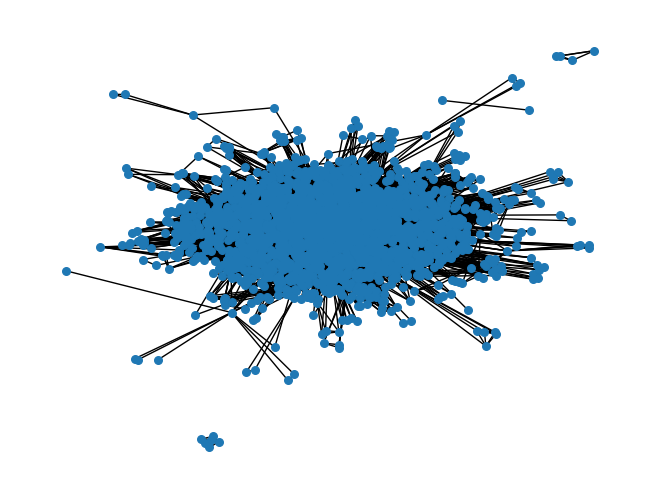

In [209]:
G = nx.Graph()
G.add_edges_from(weighted_edges)
nx.draw(G, with_labels=False, font_weight='bold', node_size=30)

## Кластеризация (Louvain) и визуализация

- Находим сообщества Louvain.
- Выводим число кластеров и модульность.
- Визуализируем топ-3 сообщества статично (matplotlib) и интерактивно (Plotly).


In [210]:
communities = nx.community.louvain_communities(G, resolution=0.9)
print(f"# of clusters: {len(communities)}, Modularity: {nx.community.modularity(G, communities)}")

# of clusters: 17, Modularity: 0.34164336420365526


In [211]:
comm_data = [{"n_of_nodes": len(comm), "nodes": comm} for comm in communities]
cdf = pd.DataFrame(comm_data)
cdf.describe()

,n_of_nodes
count,17.000000
mean,126.176471
std,127.695554
min,2.000000
25%,30.000000
50%,78.000000
75%,193.000000
max,401.000000


In [212]:
top3_comm = cdf.nlargest(3, "n_of_nodes")
top3_comm

,n_of_nodes,nodes
3,401,"{cartesian, natural, transition, lattice, loga..."
9,371,"{dataset, srio, vectorquantization, kthtipscol..."
1,280,"{legend, multiplier, huestip, home, pipeline, ..."


In [213]:
nodes = list(chain(*top3_comm["nodes"].tolist()))
S = G.subgraph(nodes)

In [215]:
for i, nodes in enumerate(top3_comm["nodes"].tolist(), start=1):
    # Get all keywords from the papers that belong to this community
    community_papers = df[df['keywords'].apply(lambda x: any(item in x for item in nodes))]
    all_keywords_in_community = [kw for sublist in community_papers['keywords'] for kw in sublist]

    print(f"\nКластер {i}, размер: {len(nodes)}")

    valid_keywords = [kw for kw in all_keywords_in_community if isinstance(kw, str) and kw.strip()]

    if valid_keywords:
        print("Топ-10 ключевых слов в кластере:")
        print(pd.Series(valid_keywords).value_counts().head(10))
    else:
        print("Нет допустимых ключевых слов в этом кластере.")


Кластер 1, размер: 401
Топ-10 ключевых слов в кластере:
image             237
algorithm          75
segmentation       72
model              66
recognition        56
detection          55
network            54
neural             43
processing         41
classification     39
Name: count, dtype: int64

Кластер 2, размер: 371
Топ-10 ключевых слов в кластере:
network                         134
neural                          102
image                            93
convolutional                    70
deep                             66
classification                   64
recognition                      61
detection                        61
convolutional neural network     37
learning                         35
Name: count, dtype: int64

Кластер 3, размер: 280
Топ-10 ключевых слов в кластере:
recognition    133
image           64
network         56
detection       44
neural          42
feature         42
vision          35
computer        30
pattern         29
human           28
Name: c

In [216]:
def create_community_node_colors(graph, communities):
    colors = list(set(mcolors.TABLEAU_COLORS.values()))
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

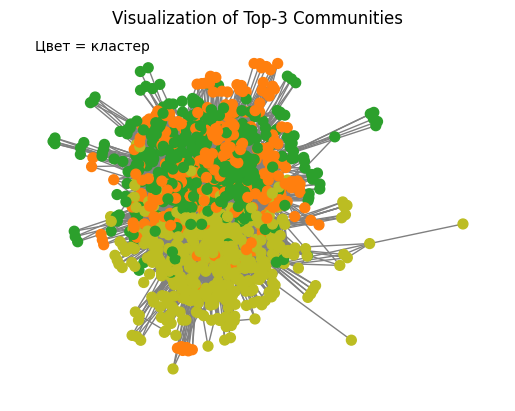

In [218]:
def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    title = f"Visualization of Top-3 Communities"
    pos = nx.spring_layout(graph, iterations=100, seed=23)
    plt.title(title)
    nx.draw(
        graph,
        pos=pos,
        node_size=50,
        node_color=node_colors,
        edge_color="gray",
        with_labels=False
    )
    plt.text(0.05, 0.95, "Цвет = кластер", transform=plt.gca().transAxes)


visualize_communities(S, top3_comm["nodes"].tolist(), 1)

In [187]:
communities = top3_comm["nodes"].tolist()
pos = nx.spring_layout(S, iterations=100, seed=23)

# edges coordinates
x_nodes, y_nodes = zip(*pos.values())
edge_x, edge_y = [], []
for edge in S.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# degree labels
node_labels = [f"Node {n}<br>Degree: {S.degree(n)}" for n in S.nodes()]
node_degrees = [S.degree(n) for n in S.nodes()]
node_colors_list = create_community_node_colors(S, communities)

fig = go.Figure()
# add edges
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color="gray"),
))

# add nodes
fig.add_trace(go.Scatter(
    x=x_nodes, y=y_nodes, mode="markers",
    marker=dict(size=[deg*1.1+5 for deg in node_degrees], color=node_colors_list),
    hoverinfo="text",
    text=node_labels
))

# background settings
fig.update_layout(
    title=f"Interactive Visualization of Top-3 Communities",
    showlegend=False,
    plot_bgcolor="white",
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
)

fig.show()

## Оценка центральностей

Вычисляем: degree, betweenness, closeness, eigenvector.
Выводим топ-5 узлов по каждой метрике. Интерпретация:
- degree → локальная важность,
- betweenness → «мосты» между кластерами,
- eigenvector → влияние через влиятельных соседей.


In [188]:
# top-10 nodes by degree centrality
[(node[0], round(node[1],2))
for node in sorted(nx.degree_centrality(S).items(), key=itemgetter(1), reverse=True)][:10]

[('image', 0.41),
 ('network', 0.28),
 ('detection', 0.23),
 ('neural', 0.21),
 ('segmentation', 0.18),
 ('convolutional', 0.16),
 ('deep', 0.15),
 ('model', 0.15),
 ('algorithm', 0.15),
 ('video', 0.12)]

In [189]:
# top nodes by degree centrality in top-3 communities

for i, nodes in enumerate(top3_comm["nodes"].tolist(), start=1):
  s = G.subgraph(nodes)
  top_node = max(nx.degree_centrality(s).items(), key=itemgetter(1))

  top3_nodes = [(node[0], round(node[1],2))
  for node in sorted(nx.degree_centrality(s).items(), key=itemgetter(1), reverse=True)][:3]

  print(f"# of cluster: {i}, Central node by degree: {(top_node[0], round(top_node[1], 2))}")
  print(f"Top-3 nodes: {top3_nodes}\n")


# of cluster: 1, Central node by degree: ('image', 0.66)
Top-3 nodes: [('image', 0.66), ('segmentation', 0.27), ('algorithm', 0.23)]

# of cluster: 2, Central node by degree: ('network', 0.62)
Top-3 nodes: [('network', 0.62), ('neural', 0.49), ('convolutional', 0.39)]

# of cluster: 3, Central node by degree: ('detection', 0.44)
Top-3 nodes: [('detection', 0.44), ('3d', 0.24), ('video', 0.24)]



In [190]:
metrics = {
    "degree": nx.degree_centrality(S),
    "betweenness": nx.betweenness_centrality(S),
    "closeness": nx.closeness_centrality(S),
    "eigenvector": nx.eigenvector_centrality(S)
}

for name, values in metrics.items():
    top5 = sorted(values.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nTop-5 {name} centrality:")
    for node, val in top5:
        print(f"{node}: {val:.3f}")



Top-5 degree centrality:
image: 0.407
network: 0.276
detection: 0.232
neural: 0.210
segmentation: 0.176

Top-5 betweenness centrality:
image: 0.304
network: 0.121
detection: 0.117
neural: 0.064
segmentation: 0.062

Top-5 closeness centrality:
image: 0.619
network: 0.565
detection: 0.551
neural: 0.542
segmentation: 0.536

Top-5 eigenvector centrality:
image: 0.295
network: 0.253
neural: 0.216
detection: 0.205
segmentation: 0.184


## Граф публикаций и поиск похожих статей

Узлы = статьи. Ребро между статьями если у них есть общие ключевые слова.
Вес = число общих ключевых слов.

Реализована функция `find_similar_papers(paper_title, graph, top_n=5)` для поиска похожих работ.


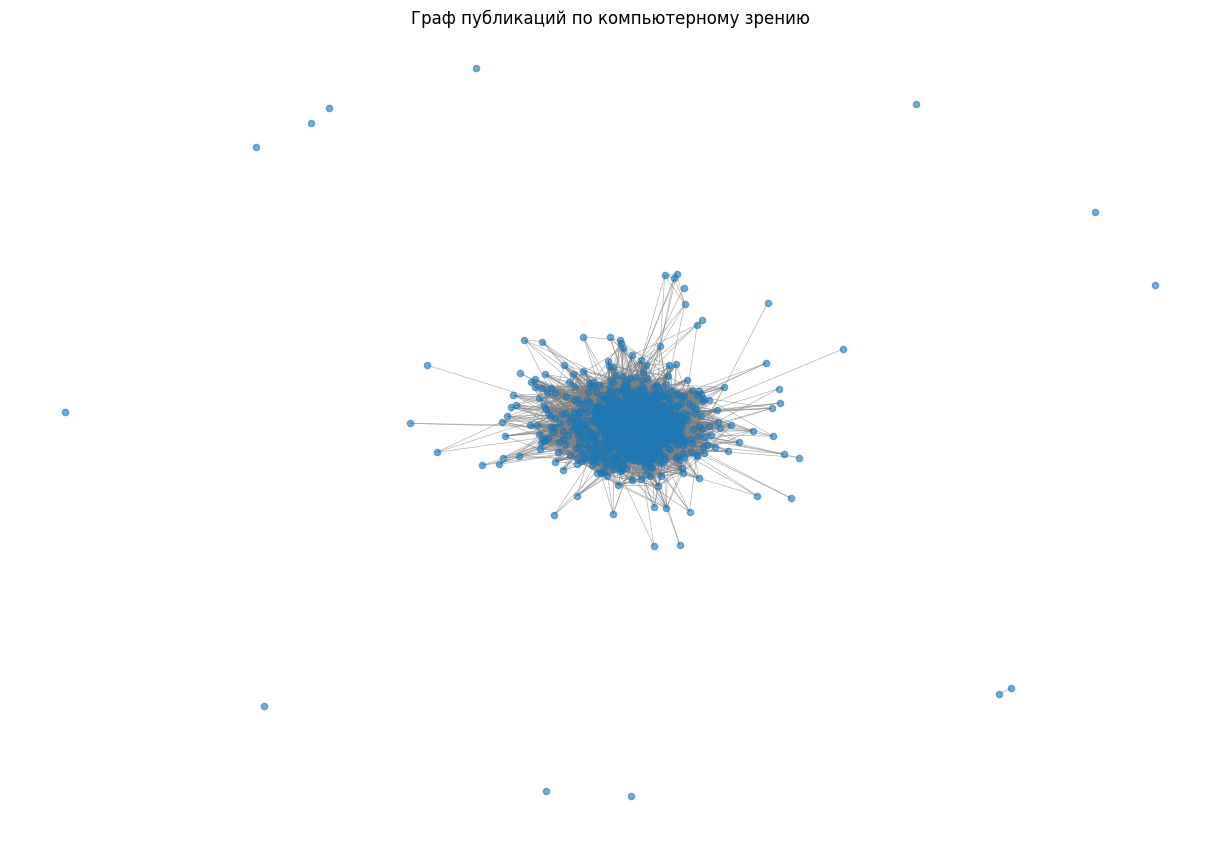

In [191]:
G_papers = nx.Graph()

for i, row in df.iterrows():
    G_papers.add_node(row['title'], abstract=row['abstract'], authors=row['authors'])

for i, row1 in df.iterrows():
    keywords1 = set(kw.strip() for kw in row1['keywords'].split(','))
    for j, row2 in df.iterrows():
        if i < j:
            keywords2 = set(kw.strip() for kw in row2['keywords'].split(','))
            common_keywords = keywords1.intersection(keywords2)
            weight = len(common_keywords)
            if weight > 0:
                G_papers.add_edge(row1['title'], row2['title'], weight=weight)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_papers, k=0.5, iterations=50)
nx.draw(G_papers, pos, node_size=20, alpha=0.6, edge_color='gray', width=0.5)
plt.title("Граф публикаций по компьютерному зрению")
plt.show()

In [192]:
def find_similar_papers(paper_title, graph, top_n=5):
    if paper_title not in graph:
        return "Статья не найдена в графе."

    # Собираем всех соседей и вес связи с ними
    neighbors = []
    for neighbor in graph.neighbors(paper_title):
        weight = graph[paper_title][neighbor]['weight']
        neighbors.append((neighbor, weight))

    # Сортируем по убыванию веса связи
    neighbors_sorted = sorted(neighbors, key=lambda x: x[1], reverse=True)
    return neighbors_sorted[:top_n]

# Пример использования
input_paper = df.iloc[3]['title']
similar = find_similar_papers(input_paper, G_papers)
for paper, weight in similar:
    print(f"Статья: {paper} | Общих ключевых слов: {weight}")

Статья: Similarity- based approach for outlier detection | Общих ключевых слов: 2
Статья: Image Segmentation Algorithms Overview | Общих ключевых слов: 2
Статья: Towards Unsupervised Familiar Scene Recognition in Egocentric Videos | Общих ключевых слов: 2
Статья: Simultaneous Object Detection, Tracking, and Event Recognition | Общих ключевых слов: 2
Статья: Review of Face Detection Systems Based Artificial Neural Networks
  Algorithms | Общих ключевых слов: 2


In [193]:
print(f"Количество статей (узлов): {G_papers.number_of_nodes()}")
print(f"Количество связей (ребер): {G_papers.number_of_edges()}")
print(f"Плотность графа: {nx.density(G_papers):.3f}")
print(f"Средняя степень связности: {sum(dict(G_papers.degree()).values()) / G_papers.number_of_nodes():.1f}")

Количество статей (узлов): 1000
Количество связей (ребер): 66059
Плотность графа: 0.132
Средняя степень связности: 132.1


## Метрики графа и качества кластеризации

Реализованы:
- Coverage разбиения,
- Conductance для сообщества,
- Средняя conductance,
- Silhouette на спектральных эмбеддингах.

Эти метрики помогут оценить качество найденных сообществ.


In [194]:
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import silhouette_score
import numpy as np

# --- Метрики графа и кластеризации ---
def coverage_of_partition(G, communities):
    m = G.number_of_edges()
    if m == 0:
        return 0.0
    intra = 0
    for comm in communities:
        intra += G.subgraph(comm).number_of_edges()
    return intra / m

def conductance_of_community(G, community):
    comm = set(community)
    cut_edges = sum(
        G[u][v].get("weight", 1.0)
        for u in comm for v in G.neighbors(u)
        if v not in comm
    )
    vol_comm = sum(G.degree(u, weight="weight") for u in comm)
    vol_rest = sum(G.degree(u, weight="weight") for u in G if u not in comm)
    denom = min(vol_comm, vol_rest)
    return cut_edges / denom if denom > 0 else 0.0

def average_conductance(G, communities):
    return np.mean([conductance_of_community(G, c) for c in communities])

def silhouette_on_embeddings(G, communities, n_components=16):
    nodes = list(G.nodes())
    A = nx.to_scipy_sparse_array(G, nodelist=nodes, weight="weight", format='csr')
    A.indices = A.indices.astype(np.int32)
    A.indptr = A.indptr.astype(np.int32)
    embed = SpectralEmbedding(n_components=n_components, affinity='precomputed').fit_transform(A)
    label_map = {}
    for cid, comm in enumerate(communities):
        for n in comm:
            label_map[n] = cid
    labels = np.array([label_map.get(n, -1) for n in nodes])
    mask = labels >= 0
    if len(set(labels[mask])) < 2:
        return float("nan")
    return silhouette_score(embed[mask], labels[mask])


# communities_all = полный список сообществ по всему графу ключевых слов
communities_all = nx.community.louvain_communities(G, resolution=0.9)

print("=== Метрики для графа ключевых слов ===")
print("Модульность:", nx.community.modularity(G, communities_all))
print("Coverage:", coverage_of_partition(G, communities_all))
print("Средняя conductance:", average_conductance(G, communities_all))
print("Silhouette (по спектральным эмбеддингам):", silhouette_on_embeddings(G, communities_all))
print()
print("=== Общие метрики графа ===")
print("Число узлов:", G.number_of_nodes())
print("Число рёбер:", G.number_of_edges())
print("Плотность графа:", nx.density(G))
print("Средний clustering coefficient:", nx.average_clustering(G))
if nx.is_connected(G):
    print("Средняя длина пути:", nx.average_shortest_path_length(G))
else:
    print("Средняя длина пути: граф несвязный")



=== Метрики для графа ключевых слов ===
Модульность: 0.3420950456875158
Coverage: 0.4813873444532698
Средняя conductance: 0.4476007477846739


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Silhouette (по спектральным эмбеддингам): -0.5270496964111412

=== Общие метрики графа ===
Число узлов: 2145
Число рёбер: 18885
Плотность графа: 0.008212869220331907
Средний clustering coefficient: 0.7858183388800734
Средняя длина пути: граф несвязный
